#    Forecasting ARIMA Model Airlines Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
airlines = pd.read_excel("Airlines+Data.xlsx")
airlines

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [3]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [4]:
airlines.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


###     Setting month as header

In [5]:
airlines = airlines.set_index('Month')

##     Visualization of Dataset

###    1) Line Plot

<AxesSubplot:xlabel='Month'>

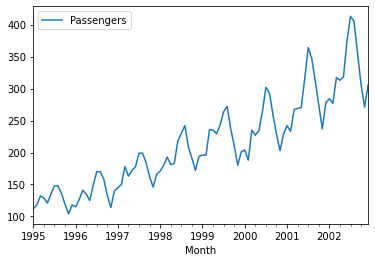

In [6]:
airlines.plot()

###      2)  Histogram

array([[<AxesSubplot:title={'center':'Passengers'}>]], dtype=object)

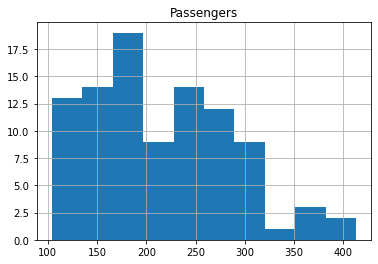

In [7]:
airlines.hist()

###     3) Density Plot

<AxesSubplot:ylabel='Density'>

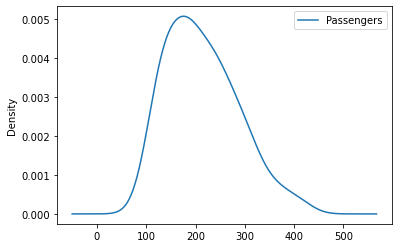

In [8]:
airlines.plot(kind='kde')

###      4) Lag Plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

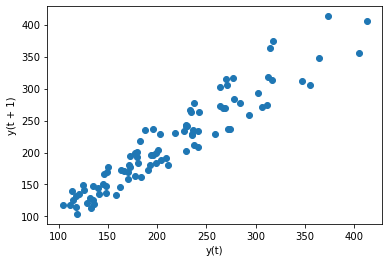

In [9]:
lag_plot(airlines)

###      5) Autocorrelation Plot

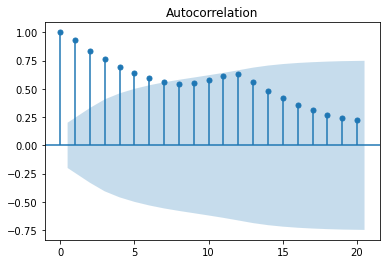

In [10]:
plot_acf(airlines,lags=20)
pyplot.show()

###     6) Partial Autocorrelation Plot

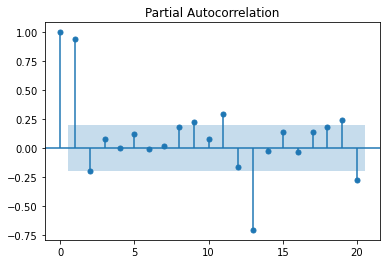

In [11]:
plot_pacf(airlines,lags=20)
pyplot.show()

##     Preprocessing

###    Train and Test Dataset 

In [12]:
split = len(airlines) - 36
Train_air, Test_air = airlines[0:split], airlines[split:]
print('Train %d, Test %d' % (len(Train_air), len(Test_air)))
Train_air.to_csv('Train_air.csv', header=False)
Test_air.to_csv('Test_air.csv', header=False) 

Train 60, Test 36


##      Naive Forecasting - Base model/Persistence

In [13]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt

In [14]:
train = read_csv('Train_air.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
train_val = train.values
train_size = int(len(train_val) * 0.50)
train_base, test_base = train_val[0:train_size], train_val[train_size:] 

In [15]:
history = [x for x in train_base]
predictions = list()
for i in range(len(test_base)):
    pred = history[-1]
    predictions.append(pred)
    observation = test_base[i]
    history.append(observation)
    print('>Predicted=%.3f, Expected=%.3f' % (pred, observation))
rmse = sqrt(mean_squared_error(test_base, predictions))
print('RMSE: %.3f' % rmse) 

>Predicted=178.000, Expected=199.000
>Predicted=199.000, Expected=199.000
>Predicted=199.000, Expected=184.000
>Predicted=184.000, Expected=162.000
>Predicted=162.000, Expected=146.000
>Predicted=146.000, Expected=166.000
>Predicted=166.000, Expected=171.000
>Predicted=171.000, Expected=180.000
>Predicted=180.000, Expected=193.000
>Predicted=193.000, Expected=181.000
>Predicted=181.000, Expected=183.000
>Predicted=183.000, Expected=218.000
>Predicted=218.000, Expected=230.000
>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>

##     ARIMA Model 

In [16]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

In [17]:
def arima_model(train_val, arima_order):
    train_size = int(len(train_val) * 0.50)
    train, test = train_val[0:train_size], train_val[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        pred = model_fit.forecast()[0]
        predictions.append(pred)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse  

In [18]:
def evaluate_models(Train, p_val, d_val, q_val):
    best_score, best_cfg = float('inf'), None
    for p in p_val:
        for d in d_val:
            for q in q_val:
                order = (p,d,q)
                try:
                    rmse = arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))  

In [19]:
train = read_csv('Train_air.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
p_val = range(0, 3)
d_val = range(0, 3)
q_val = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_val, d_val, q_val)  

ARIMA(0, 0, 1) RMSE=33.974
ARIMA(0, 1, 1) RMSE=19.554
ARIMA(0, 1, 2) RMSE=21.365
ARIMA(0, 2, 1) RMSE=20.681
ARIMA(0, 2, 2) RMSE=20.184
ARIMA(1, 0, 0) RMSE=20.369
ARIMA(1, 0, 1) RMSE=20.298
ARIMA(1, 1, 0) RMSE=19.732
ARIMA(1, 2, 0) RMSE=23.982
ARIMA(2, 0, 0) RMSE=20.186
ARIMA(2, 0, 1) RMSE=21.146
ARIMA(2, 1, 0) RMSE=19.694
ARIMA(2, 2, 0) RMSE=24.028
ARIMA(2, 2, 1) RMSE=20.334
Best ARIMA(0, 1, 1) RMSE=19.554


###      Building model using optimised value on train and test dataset

In [20]:
train = read_csv('Train_air.csv', header=None, index_col=0, parse_dates=True,squeeze=True)
train_val = train.values

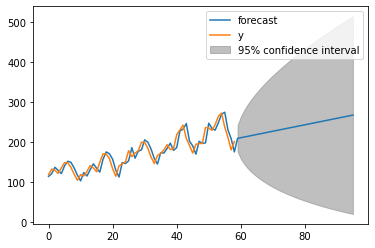

In [21]:
model = ARIMA(train_val, order=(0,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=36)[0]
model_fit.plot_predict(1,96) 
pyplot.show()

In [22]:
forecast

array([208.86201473, 210.48166593, 212.10131713, 213.72096833,
       215.34061952, 216.96027072, 218.57992192, 220.19957312,
       221.81922432, 223.43887552, 225.05852672, 226.67817792,
       228.29782912, 229.91748032, 231.53713152, 233.15678271,
       234.77643391, 236.39608511, 238.01573631, 239.63538751,
       241.25503871, 242.87468991, 244.49434111, 246.11399231,
       247.73364351, 249.3532947 , 250.9729459 , 252.5925971 ,
       254.2122483 , 255.8318995 , 257.4515507 , 259.0712019 ,
       260.6908531 , 262.3105043 , 263.9301555 , 265.54980669])

In [23]:
val=pd.read_csv('Test_air.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse 

64.26072691660183

###     Building Final Model using original dataset

In [24]:
airlines.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [25]:
airlines_val = airlines.values

In [26]:
model = ARIMA(airlines_val, order=(0,1,1))
model_fit = model.fit() 

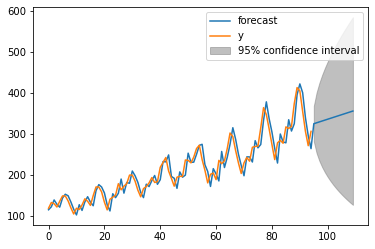

In [27]:
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,110) 
pyplot.show()

In [28]:
forecast

array([324.73106062, 326.94364843, 329.15623623, 331.36882404,
       333.58141185, 335.79399965, 338.00658746, 340.21917527,
       342.43176307, 344.64435088, 346.85693869, 349.06952649])

###   Thus using ARIMA model, forecasted dataset for the next one years 